In [32]:
import pandas as pd
from pathlib import Path
import json
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from datetime import datetime
import re
from scipy import stats
import numpy as np
import statsmodels.api as sm
from matplotlib import colormaps
from scipy.optimize import curve_fit
from tqdm.notebook import tqdm
from collections import defaultdict
import statsmodels.formula.api as smf

from mri_data import file_manager as fm

See if I can use NIND group to adjust the subnuclei changes ([this paper](https://pmc.ncbi.nlm.nih.gov/articles/PMC11087027/) as inspiration)

In [10]:
drive_root = fm.get_drive_root()
dataroot = drive_root / "3Tpioneer_bids"
work_home = drive_root / "srs-9/longitudinal"
data_dir = Path("/home/srs-9/Projects/ms_mri/data")
date_format = "%Y%m%d"
fig_path = Path("/home/srs-9/Projects/ms_mri/choroid_thalamus_project/figures")

choroid_volumes = pd.read_csv("/home/srs-9/Projects/ms_mri/data/choroid_aschoplex_volumes.csv",
                              index_col="subid").dropna()

thalamic_nuclei = [2, 4, 5, 6, 7, 8, 9, 10, 11, 12]
thalamic_nuclei_str = [str(i) for i in thalamic_nuclei]

hips_thomas_ref = pd.read_csv("/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", 
                              index_col="index")
hips_thomas_ref.rename(columns={"struct": "struct_name"}, inplace=True)
hips_thomas_ref = pd.Series(hips_thomas_ref['struct_name'])
main_index = hips_thomas_ref.index[~hips_thomas_ref.index.isin([1, 33, 34])]

with open(dataroot / "subject-sessions-longit.json", 'r') as f:
    subject_sessions = json.load(f)

choroid_dists = pd.read_csv(data_dir / "centroid-choroid_centroid.csv", index_col="subid")
choroid_dists["1"] = 4

ventricle_dists = pd.read_csv(data_dir / "centroid-ventricle_SDT.csv", index_col="subid")
ventricle_dists["1"] = 4

tiv = pd.read_csv("/home/srs-9/Projects/ms_mri/data/tiv_data.csv", index_col="subid")
df_clinical = pd.read_csv("/home/srs-9/Projects/ms_mri/data/clinical_data_processed.csv", index_col="subid")
df_clinical = df_clinical.join([choroid_volumes, tiv])

viridis = colormaps['viridis'].resampled(20)

all_subjects = []
for folder in work_home.glob("sub*"):
    if len(list((folder / "left").glob("*.csv"))) > 0 and len(list((folder / "right").glob("*.csv"))) > 0:
        all_subjects.append(re.match(r"sub(\d{4})", folder.name)[1])
    else:
        print(folder)
all_subjects.remove("1064")
all_subids = [int(sub) for sub in all_subjects]

choroid_changes = pd.read_csv("/home/srs-9/Projects/ms_mri/data/choroid_longitudinal_changes.csv", index_col="subid")
choroid_changes['abs_change'] = choroid_changes['volume2'] - choroid_changes['volume1']
choroid_changes['norm_change'] = choroid_changes['abs_change'] / choroid_changes['t_delta']

mni_dists = pd.read_csv("/home/srs-9/Projects/ms_mri/data/mni_centroid_centroid_dists.csv", index_col="index")

/media/smbshare/srs-9/longitudinal/sub1163


In [24]:
def get_subject_data(subid):
    sessions = sorted(subject_sessions[subid])
    work_dir = work_home / f"sub{subid}"

    index = hips_thomas_ref.index[~hips_thomas_ref.index.isin([34, 33])]
    session_volumes = defaultdict(list)
    # just copy first and last to speed things up
    sessions = sorted(sessions)
    sessions = [sessions[0], sessions[-1]]
    for sesid in sessions:
        ses_dataL = pd.read_csv(work_dir / "left" / f"hipsthomas_full_jacobianinv-{sesid}.csv", index_col="struct")
        ses_dataR = pd.read_csv(work_dir / "right" / f"hipsthomas_full_jacobianinv-{sesid}.csv", index_col="struct")
        vols = []
        for i in index:
            left_vol = ses_dataL.loc[i, 'volumes'] / ses_dataL.loc[i, 'jac_det']
            right_vol = ses_dataR.loc[i, 'volumes'] / ses_dataR.loc[i, 'jac_det']
            vols.append(left_vol+right_vol)
            # vols.append(left_vol)
        session_volumes[sesid] = vols

    df = pd.DataFrame(session_volumes, index=index)
    data = pd.DataFrame({}, index=df.index)
    for ind in data.index:
        data.loc[ind, 'choroid_dist'] = choroid_dists.loc[int(subid), str(ind)]
        data.loc[ind, 'ventricle_dist'] = ventricle_dists.loc[int(subid), str(ind)]
    # data['choroid_dist'] = choroid_dists.loc[int(subid), :].tolist()
    # data['ventricle_dist'] = ventricle_dists.loc[int(subid), :].tolist()
    changes = [(row[sessions[-1]] - row[sessions[0]])/row[sessions[0]] for _,row in df.iterrows()]
    vol1 = df[sessions[0]]
    vol2 = df[sessions[1]]
    # changes = [(row[sessions[-1]]/row[sessions[0]]) for _,row in df.iterrows()]

    # changes = [change / max([np.abs(max(changes)), np.abs(min(changes))]) for change in changes]
    data['change'] = changes
    data['vol1'] = vol1
    data['vol2'] = vol2

    delta = datetime.strptime(str(df.columns[-1]), date_format) - datetime.strptime(str(df.columns[0]), date_format)
    t_delta = delta.days / 365

    return {'data': data, 't_delta': t_delta}

In [78]:
subjects = [subid for subid in all_subjects if df_clinical.loc[int(subid), "dz_type2"] == "MS"]
# subjects = [subid for subid in subjects if df_clinical.loc[int(subid), "dzdur"] < 8]
# subjects = [subid for subid in all_subjects if df_clinical.loc[int(subid), "dz_type5"] == "RMS"]
# subjects = all_subjects
# subjects = subjects[11:24]
data_structs = {}
for subid in subjects:
    try:
        data_structs[subid] = get_subject_data(subid)
    except Exception:
        print(f"Failed {subid}")
        continue
data_eg = data_structs[subjects[0]]['data']
print(len(subjects))

/tmp/ipykernel_6863/374536539.py:28: RuntimeWarning: invalid value encountered in scalar divide
  changes = [(row[sessions[-1]] - row[sessions[0]])/row[sessions[0]] for _,row in df.iterrows()]


78


In [125]:
covariates = ["age", "Female", "tiv", "choroid_volume", "t2lv_logtrans", "PRL", "dzdur"]
data_frames = []
for subid in subjects:
    data_struct = data_structs[subid]
    data = data_struct['data']
    thalamus_change = data.loc[1, 'change']
    thalamus_vol1 = data.loc[1, 'vol1']
    thalamus_vol2 = data.loc[1, 'vol2']
    data = data.loc[~data.index.isin([1]), :]
    data = data.reset_index()
    data['thalamus_change'] = thalamus_change
    data['thalamus_vol1'] = thalamus_vol1
    data['thalamus_vol2'] = thalamus_vol2
    data['t_delta'] = data_struct['t_delta']
    data['subid'] = subid
    for covar in covariates:
        data[covar] = df_clinical.loc[int(subid), covar]
    data_frames.append(data)

full_df = pd.concat(data_frames, axis=0, ignore_index=True)
numeric_cols = full_df.select_dtypes(include='number').columns

for col in numeric_cols:
    full_df.loc[full_df[col].isna(), col] = full_df[col].mean()
full_df['index'] = full_df['index'].astype("int")
for i, name in hips_thomas_ref.items():
    full_df.loc[full_df['index'] == i, "struct_name"] = name

/tmp/ipykernel_6863/552313624.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '15.25' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  full_df.loc[full_df[col].isna(), col] = full_df[col].mean()


In [127]:
model_data = full_df.copy()
numeric_cols = model_data.select_dtypes(np.number).columns
for col in numeric_cols:
    model_data.loc[model_data[col].isna(), col] = model_data[col].mean()

model_data = model_data[model_data['index'].isin(thalamic_nuclei)]
model_data[numeric_cols] = model_data[numeric_cols].apply(stats.zscore, nan_policy="omit")
formula = "vol2 ~ choroid_dist"
md = smf.mixedlm(formula, model_data, groups=model_data['subid'], missing='omit')
mdf = md.fit()
print(mdf.summary())

model_data.to_csv("longitudinal_for_R_MS_thalamus.csv")

/tmp/ipykernel_6863/3222068789.py:1: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  model_data = full_df.interpolate()


         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: vol2      
No. Observations: 780     Method:             REML      
No. Groups:       78      Scale:              0.8064    
Min. group size:  10      Log-Likelihood:     -1028.6824
Max. group size:  10      Converged:          No        
Mean group size:  10.0                                  
--------------------------------------------------------
             Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      0.000    0.044  0.000 1.000 -0.087  0.087
choroid_dist   0.052    0.024  2.180 0.029  0.005  0.099
age           -0.039    0.048 -0.818 0.414 -0.134  0.055
Female         0.033    0.048  0.692 0.489 -0.061  0.128
t_delta       -0.088    0.045 -1.958 0.050 -0.176  0.000
Group Var      0.110    0.028                           



/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 18.502079
  warnings.warn(msg, ConvergenceWarning)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [30]:
model_data

,index,choroid_dist,ventricle_dist,change,vol1,vol2,t_delta,subid,age,Female,tiv,choroid_volume,t2lv_logtrans,PRL,dzdur,struct_name
1,-1.776470,0.424987,-1.025613,2.470436,-0.820809,-0.809460,0.065392,1003,1.611306,0.547723,0.011224,0.195467,0.353863,-0.404158,0.551698,AV_2
2,-1.118518,1.213261,-0.573898,1.043863,-0.300015,-0.267937,0.065392,1003,1.611306,0.547723,0.011224,0.195467,0.353863,-0.404158,0.551698,VA_4
3,-0.789542,0.946367,-1.478838,-0.191950,-0.729744,-0.734853,0.065392,1003,1.611306,0.547723,0.011224,0.195467,0.353863,-0.404158,0.551698,VLa_5
4,-0.460566,0.140571,-0.741851,1.374703,0.943257,1.074982,0.065392,1003,1.611306,0.547723,0.011224,0.195467,0.353863,-0.404158,0.551698,VLP_6
5,-0.131590,0.119155,-0.835956,-0.555388,-0.069816,-0.090469,0.065392,1003,1.611306,0.547723,0.011224,0.195467,0.353863,-0.404158,0.551698,VPL_7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1546,0.197386,-0.710335,-0.093757,-0.227365,0.542592,0.533865,1.168119,3021,0.630736,0.547723,0.750597,0.988841,0.648602,-0.404158,1.133413,Pul_8
1547,0.526361,1.248405,0.003804,-1.058398,-0.822886,-0.833156,1.168119,3021,0.630736,0.547723,0.750597,0.988841,0.648602,-0.404158,1.133413,LGN_9
1548,0.855337,-0.955665,1.105275,-0.774508,-0.829976,-0.838329,1.168119,3021,0.630736,0.547723,0.750597,0.988841,0.648602,-0.404158,1.133413,MGN_10
1549,1.184313,-0.965735,0.991992,-0.049467,-0.728609,-0.732231,1.168119,3021,0.630736,0.547723,0.750597,0.988841,0.648602,-0.404158,1.133413,CM_11


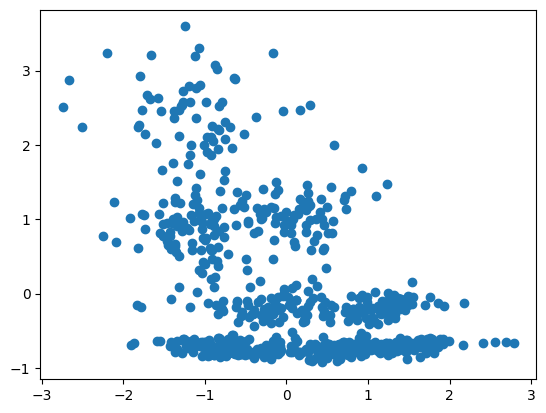

In [31]:
plt.scatter(model_data['choroid_dist'], model_data['vol2'])

In [52]:
data = sm.datasets.get_rdataset("dietox", "geepack").data

In [41]:
full_df.loc[1559, "subid"]

'3021'

In [44]:
data

,Pig,Evit,Cu,Litter,Start,Weight,Feed,Time
0,4601,Evit000,Cu000,1,26.5,26.50000,NaN,1
1,4601,Evit000,Cu000,1,26.5,27.59999,5.200005,2
2,4601,Evit000,Cu000,1,26.5,36.50000,17.600000,3
3,4601,Evit000,Cu000,1,26.5,40.29999,28.500000,4
4,4601,Evit000,Cu000,1,26.5,49.09998,45.200001,5
...,...,...,...,...,...,...,...,...
856,8442,Evit000,Cu175,24,25.7,73.19995,83.800003,8
857,8442,Evit000,Cu175,24,25.7,81.69995,99.800003,9
858,8442,Evit000,Cu175,24,25.7,90.29999,115.200001,10
859,8442,Evit000,Cu175,24,25.7,96.00000,133.200001,11


In [54]:
md = smf.mixedlm("Weight ~ Time", data, groups=data["Pig"])
mdf = md.fit()
print(mdf.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Weight    
No. Observations: 861     Method:             REML      
No. Groups:       72      Scale:              11.3669   
Min. group size:  11      Log-Likelihood:     -2404.7753
Max. group size:  12      Converged:          Yes       
Mean group size:  12.0                                  
--------------------------------------------------------
             Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept    15.724    0.788  19.952 0.000 14.179 17.268
Time          6.943    0.033 207.939 0.000  6.877  7.008
Group Var    40.394    2.149                            

